In [1]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii

In [2]:
#kaguya_file = '/scratch/arsanders/kaguyatc/TC2S2B0_01_03043N107E3384.img'
#kaguya_file = '/home/arsanders/testData/apollo/AS15-M-1450.lbl'
marci_file = '/home/arsanders/testData/marci/T02_001251_1292_MU_00N237W.IMG'
image_file = marci_file

In [3]:
header = pvl.load(marci_file)
header

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('FILE_NAME', 'T02_001251_1292_MU_00N237W.IMG')
  ('RECORD_TYPE', 'FIXED_LENGTH')
  ('RECORD_BYTES', 128)
  ('FILE_RECORDS', 2443)
  ('LABEL_RECORDS', 11)
  ('^IMAGE', 12)
  ('SPACECRAFT_NAME', 'MARS_RECONNAISSANCE_ORBITER')
  ('INSTRUMENT_NAME', 'MARS COLOR IMAGER')
  ('INSTRUMENT_HOST_NAME', 'MARS RECONNAISSANCE ORBITER')
  ('MISSION_PHASE_NAME', 'TRANSITION')
  ('TARGET_NAME', 'MARS')
  ('INSTRUMENT_ID', 'MARCI')
  ('PRODUCER_ID', 'MRO_MARCI_TEAM')
  ('DATA_SET_ID', 'MRO-M-MARCI-2-EDR-L0-V1.0')
  ('PRODUCT_CREATION_TIME',
   datetime.datetime(2007, 5, 18, 18, 47, 48, tzinfo=datetime.timezone.utc))
  ('SOFTWARE_NAME', 'makepds05 $Revision: 1.7 $')
  ('UPLOAD_ID', 'UNK')
  ('ORIGINAL_PRODUCT_ID', '4A_05_1002812900')
  ('PRODUCT_ID', 'T02_001251_1292_MU_00N237W')
  ('START_TIME',
   datetime.datetime(2006, 11, 1, 22, 45, 53, 570000, tzinfo=datetime.timezone.utc))
  ('STOP_TIME',
   datetime.datetime(2006, 11, 1, 23, 49, 50, 370000, tzinfo=date

In [4]:
with open(marci_file, 'rb') as f:
    try:
        image_offset = ((header["^IMAGE"]-1) * header["RECORD_BYTES"]) - (header['IMAGE']['SAMPLE_BITS']//8)
        f.seek(image_offset)
        b_image_data = f.read()
    except AttributeError:
        # If detached label, "^IMAGE" will be a list.
        image_file = os.path.dirname(marci_file) + "/" + header["^IMAGE"][0]
        image_offset = header["^IMAGE"][1].value
        with open(image_file, 'rb') as im_f:
            b_image_data = im_f.read()

In [5]:
n_lines = 100
line_length = header['IMAGE']['LINE_SAMPLES'] * (header['IMAGE']['SAMPLE_BITS']//8)

In [6]:
image_data = []
for j in range(n_lines):
    image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length], dtype=np.uint8, count=int(line_length))
    image_data.append(image_sample)
image_data = np.array(image_data)

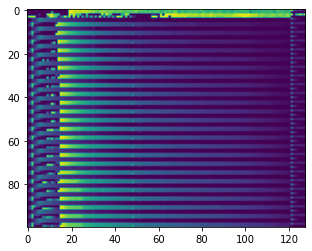

In [7]:
plt.imshow(image_data)

In [8]:
class RealIsisCubeLabelEncoder(pvl.encoder.ISISEncoder):    
    def encode_time(self, value):
        if value.microsecond:
            second = u'%02d.%06d' % (value.second, value.microsecond)
        else:
            second = u'%02d' % value.second

        time = u'%02d:%02d:%s' % (value.hour, value.minute, second)
        return time

In [9]:
image_fn, image_ext = os.path.splitext(image_file)
crop = '_cropped'
mini_image_fn = image_fn + crop + image_ext
mini_image_bn = os.path.basename(mini_image_fn)

grammar = pvl.grammar.ISISGrammar()
grammar.comments+=(("#", "\n"), )
encoder = RealIsisCubeLabelEncoder()

# Overwrite the number of lines in the label
header['IMAGE']['LINES'] = n_lines

if marci_file != image_file:
    # If detached label, point the mini label to the mini image
    header['FILE_NAME'] = mini_image_bn
else:
    # If attached label, calculate the new offset
    header['^IMAGE'] = pvl.collections.Units(len(pvl.dumps(header, encoder=encoder, grammar=grammar)), 'BYTES')

In [10]:
label_fn, label_ext = os.path.splitext(marci_file)
out_label = label_fn + crop + label_ext

pvl.dump(header, out_label, encoder=encoder, grammar=grammar)

1796

In [11]:
with open(mini_image_fn, 'ab+') as f:
    b_reduced_image_data = image_data.tobytes()
    #f.seek(0, 2)
    f.write(b_reduced_image_data)